In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
# import tensorflow_hub as hub
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = 2

from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


2024-04-04 18:32:47.662322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 18:32:47.689499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 18:32:47.689522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 18:32:47.690337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 18:32:47.695214: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class_labels = os.listdir('Dataset/Training')
class_labels

['meningioma', 'glioma', 'pituitary', 'notumor']

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('Dataset/Training', 
                                                 target_size = (224, 224), 
                                                 batch_size = 8,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 5712 images belonging to 4 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('Dataset/Testing',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 1311 images belonging to 4 classes.


In [5]:
type(training_set)

keras.src.preprocessing.image.DirectoryIterator

In [6]:

# Load the EfficientNetV2-S base model (pre-trained on ImageNet)
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),  # Adjust input shape as needed
    #include_preprocessing=True  # Keep preprocessing enabled
)

base_model.trainable = True
# Add a Global Average Pooling layer to reduce spatial dimensions
gap_layer = GlobalAveragePooling2D()(base_model.output)

# Create your custom model by adding additional layers
dense_layer1 = Dense(units=4096, activation='relu')(gap_layer)
dropout1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(units=4096, activation='relu')(dense_layer1)
dropout2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(units=4, activation='softmax')(dropout2)

# Define the complete model
efficient_net = keras.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
efficient_net.compile(optimizer=Adam(), loss= 'categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
efficient_net.summary()


2024-04-04 18:32:49.876783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 18:32:49.903372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 18:32:49.903423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 18:32:49.907076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 18:32:49.907134: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                           

In [7]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

In [8]:
#history = efficient_net.fit(training_set,validation_data =  test_set, epochs=50 , verbose = 2)

history = efficient_net.fit(
    training_set,
    validation_data=test_set,
    callbacks=[early_stopping],
    epochs=100  # Set an arbitrary large number of epochs
)

Epoch 1/100


2024-04-04 18:33:14.711806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-04 18:33:17.773530: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-04 18:33:17.877120: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 18:33:18.220781: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 18:33:19.538445: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff10c768100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 18:33:19.538479: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

714/714 [==============================] - 182s 190ms/step - loss: 0.6642 - accuracy: 0.7850 - val_loss: 2.7528 - val_accuracy: 0.3089
Epoch 2/100
714/714 [==============================] - 135s 189ms/step - loss: 0.3904 - accuracy: 0.8701 - val_loss: 1.3890 - val_accuracy: 0.4241
Epoch 3/100
714/714 [==============================] - 134s 188ms/step - loss: 0.2551 - accuracy: 0.9168 - val_loss: 6.7286 - val_accuracy: 0.3089
Epoch 4/100
714/714 [==============================] - 135s 189ms/step - loss: 0.2397 - accuracy: 0.9228 - val_loss: 1.3247 - val_accuracy: 0.5690
Epoch 5/100
714/714 [==============================] - 134s 188ms/step - loss: 0.1855 - accuracy: 0.9400 - val_loss: 0.2489 - val_accuracy: 0.9153
Epoch 6/100
714/714 [==============================] - 135s 189ms/step - loss: 0.1591 - accuracy: 0.9491 - val_loss: 0.6787 - val_accuracy: 0.7338
Epoch 7/100
714/714 [==============================] - 134s 188ms/step - loss: 0.1361 - accuracy: 0.9541 - val_loss: 1.3985 - val_

In [9]:
efficient_net.save('BrainTumor.h5')
efficient_net.save_weights ('BrainTumor.h5')

/home/sagnik/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


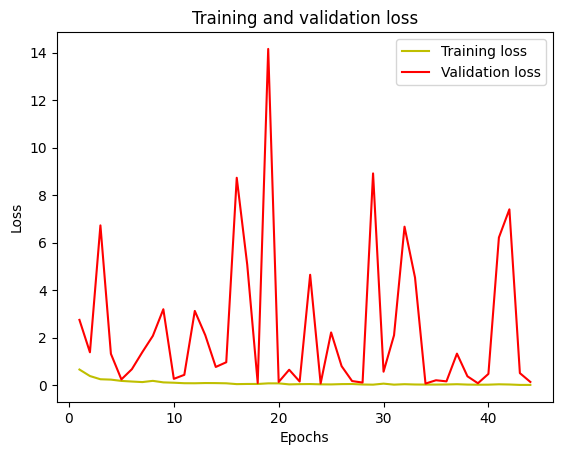

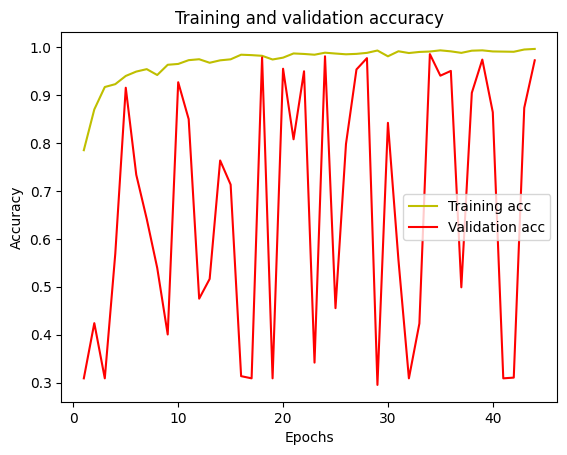

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Assuming `x_test` and `y_test` are your test data and labels
test_loss, test_accuracy = efficient_net.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


164/164 [==============================] - 8s 48ms/step - loss: 0.0732 - accuracy: 0.9855
Test Loss: 0.07318753749132156, Test Accuracy: 0.9855072498321533


In [13]:
y_pred = efficient_net.predict(test_set)
y_pred

164/164 [==============================] - 9s 44ms/step


array([[9.9999988e-01, 1.2079227e-07, 9.7306485e-10, 2.8128597e-09],
       [9.9999619e-01, 3.5926341e-06, 8.1286416e-08, 1.8103486e-07],
       [9.9999988e-01, 7.1471149e-08, 4.5066098e-10, 1.4904292e-09],
       ...,
       [1.2122803e-11, 6.6185071e-11, 3.0644741e-13, 1.0000000e+00],
       [1.6418514e-12, 4.9363582e-12, 1.6106216e-14, 1.0000000e+00],
       [3.7309236e-12, 1.4834483e-11, 5.8805642e-14, 1.0000000e+00]],
      dtype=float32)

In [14]:
y_pred_new = 1*(y_pred > 0.5)
y_pred_new

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [15]:
y_test_set = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
y_test_set = y_test_set.astype(int)
y_test_set = y_test_set.reshape(len(y_test_set), 4)
print(y_test_set)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score
import numpy as np

# Assuming y_test and y_pred are your true and predicted labels respectively
y_test_decoded = np.argmax(y_test_set, axis=1)
y_pred_decoded = np.argmax(y_pred_new, axis=1)

cm = confusion_matrix(y_test_decoded, y_pred_decoded)
acc= accuracy_score(y_test_set, y_pred_new)
print(acc,"\n")
print(cm)


0.984744469870328 

[[290   8   0   2]
 [  1 298   3   4]
 [  0   0 405   0]
 [  0   0   0 300]]
